# Q1. De-identification:

In [41]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id, concat, lit, lpad, col, countDistinct, datediff , mean , row_number, first, to_date

In [ ]:
# Step 1: Start Spark session
spark = SparkSession.builder \
    .appName("DeIdentification") \
    .getOrCreate()

In [15]:
# Step 2: Read CSV files
admissions_surg = spark.read.option("header", True).csv("admissions_surg.csv")
admissions_med = spark.read.option("header", True).csv("admissions_med.csv")
imaging = spark.read.option("header", True).csv("imaging.csv")

# Compile a list of values from the ID column from both admissions_surg and admissions_med.
# Step 3a: Compile list of IDs from both admissions datasets
all_ids_df = admissions_surg.select("ID").union(admissions_med.select("ID")).distinct()

# Create a new object called q1b and assign a unique identifier called DE_ID for every ID
# Step 3b: Create q1b with DE_ID
q1b = all_ids_df.withColumn("row_num", monotonically_increasing_id()) \
    .withColumn("DE_ID", concat(lit("DE"), lpad((col("row_num") + 1).cast("string"), 4, "0"))) \
    .drop("row_num")

print("First 10 rows of q1b:")
q1b.show(10, truncate=False)

#Show that every row of DE_ID from q1b is unique
# Step 3c: Check DE_ID uniqueness
is_unique = q1b.select(countDistinct("DE_ID")).first()[0] == q1b.count()
print("Are all DE_IDs unique?:", is_unique)

# Step 3d: De-identify datasets by joining with q1b
admissions_surg_deid = admissions_surg.join(q1b, on="ID", how="left").drop("ID")
admissions_med_deid = admissions_med.join(q1b, on="ID", how="left").drop("ID")
imaging_deid = imaging.join(q1b, on="ID", how="left").drop("ID")

print("Admissions Surgical (De-identified):")
admissions_surg_deid.show(5, truncate=False)

print("Admissions Medical (De-identified):")
admissions_med_deid.show(5, truncate=False)

print("Imaging (De-identified):")
imaging_deid.show(5, truncate=False)


First 10 rows of q1b:
+-----+------+
|ID   |DE_ID |
+-----+------+
|20158|DE0001|
|28135|DE0002|
|38223|DE0003|
|45300|DE0004|
|59169|DE0005|
|82993|DE0006|
|8306 |DE0007|
|27966|DE0008|
|41256|DE0009|
|52364|DE0010|
+-----+------+
only showing top 10 rows

Are all DE_IDs unique?: True
Admissions Surgical (De-identified):
+--------------+--------------+--------------+--------------+---------------+------+----+--------------------+----------------------------------------+------+
|ADMISSION.DATE|ADMISSION.TIME|DISCHARGE.DATE|DISCHARGE.TIME|DEPARTMENT     |GENDER|AGE |MAIN.DIAGNOSIS.ICD10|MAIN.DIAGNOSIS.NAME                     |DE_ID |
+--------------+--------------+--------------+--------------+---------------+------+----+--------------------+----------------------------------------+------+
|1998-02-01    |07:02         |1998-03-31    |07:17         |General Surgery|M     |NULL|E0800               |Diabetes mellitus with complications    |DE0609|
|2010-11-30    |04:33         |2011-03-2

# Q2. Create one data frame called admissions_img, consisting of all rows in admissions_surg and admissions_med, merged with the imaging data using DE_ID (retaining all DE_IDs from both).

In [16]:
admissions_med_deid.printSchema()
admissions_surg_deid.printSchema()

root
 |-- admission_date: string (nullable = true)
 |-- admission_time: string (nullable = true)
 |-- discharge_date: string (nullable = true)
 |-- discharge_time: string (nullable = true)
 |-- department: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- main_diagnosis_icd10: string (nullable = true)
 |-- main_diagnosis_name: string (nullable = true)
 |-- DE_ID: string (nullable = true)

root
 |-- ADMISSION.DATE: string (nullable = true)
 |-- ADMISSION.TIME: string (nullable = true)
 |-- DISCHARGE.DATE: string (nullable = true)
 |-- DISCHARGE.TIME: string (nullable = true)
 |-- DEPARTMENT: string (nullable = true)
 |-- GENDER: string (nullable = true)
 |-- AGE: string (nullable = true)
 |-- MAIN.DIAGNOSIS.ICD10: string (nullable = true)
 |-- MAIN.DIAGNOSIS.NAME: string (nullable = true)
 |-- DE_ID: string (nullable = true)



In [19]:
print(admissions_med_deid.count())
print(admissions_surg_deid.count())

2305
1195


In [21]:
# Fix: Rename admission_med_deid to match column names
admissions_surg_renamed = admissions_surg_deid.select(
    col("`ADMISSION.DATE`").alias("admission_date"),
    col("`ADMISSION.TIME`").alias("admission_time"),
    col("`DISCHARGE.DATE`").alias("discharge_date"),
    col("`DISCHARGE.TIME`").alias("discharge_time"),
    col("DEPARTMENT").alias("department"),
    col("GENDER").alias("gender"),
    col("AGE").alias("age"),
    col("`MAIN.DIAGNOSIS.ICD10`").alias("main_diagnosis_icd10"),
    col("`MAIN.DIAGNOSIS.NAME`").alias("main_diagnosis_name"),
    col("DE_ID")
)

admissions_med_renamed = admissions_med_deid.select(
    "admission_date",
    "admission_time",
    "discharge_date",
    "discharge_time",
    "department",
    "gender",
    "age",
    "main_diagnosis_icd10",
    "main_diagnosis_name",
    "DE_ID"
)

# Union the admissions datasets (matching schemas)
admissions_all = admissions_surg_renamed.unionByName(admissions_med_renamed)
# Join with imaging on DE_ID (note case: make sure columns are consistent)
admissions_img = admissions_all.join(imaging_deid, on="DE_ID", how="left")

admissions_img.show(5, truncate=False)
print(admissions_all.count())
print(admissions_img.count())

+------+--------------+--------------+--------------+--------------+---------------+------+----+--------------------+----------------------------------------+----------------+-----------------+--------------+--------------+-----------------+--------------------------+
|DE_ID |admission_date|admission_time|discharge_date|discharge_time|department     |gender|age |main_diagnosis_icd10|main_diagnosis_name                     |test_name       |ordered_date_time|performed_date|performed_time|technician_name  |brief_report              |
+------+--------------+--------------+--------------+--------------+---------------+------+----+--------------------+----------------------------------------+----------------+-----------------+--------------+--------------+-----------------+--------------------------+
|DE0609|1998-02-01    |07:02         |1998-03-31    |07:17         |General Surgery|M     |NULL|E0800               |Diabetes mellitus with complications    |US              |NA               |

In [23]:
admissions_img.select("*").filter(admissions_img["DE_ID"]=="DE0755").show()

+------+--------------+--------------+--------------+--------------+---------------+------+---+--------------------+-------------------+--------------+-----------------+--------------+--------------+-----------------+--------------------+
| DE_ID|admission_date|admission_time|discharge_date|discharge_time|     department|gender|age|main_diagnosis_icd10|main_diagnosis_name|     test_name|ordered_date_time|performed_date|performed_time|  technician_name|        brief_report|
+------+--------------+--------------+--------------+--------------+---------------+------+---+--------------------+-------------------+--------------+-----------------+--------------+--------------+-----------------+--------------------+
|DE0755|    2015-03-05|         09:40|    2015-08-28|         04:51|General Surgery|     M| 92|                O045|   Induced abortion|RT LEG DOPPLER|               NA|    2015-05-21|         02:44|       marco carr|On visual analysi...|
|DE0755|    2015-03-05|         09:40|    20

# Q3. In admissions_img, create a new length_of_stay variable defined as discharge date and time minus admission date and time (in days). Create a data frame called los by calculating the mean length_of_stay for each department.

In [38]:
admissions_img1 = admissions_img.withColumn("length_of_stay",datediff (col("discharge_date"),col("admission_date")))
los = admissions_img1.groupBy("department").agg(mean(admissions_img1["length_of_stay"])).alias("mean_length_of_stay")

In [39]:
los.show()

+--------------------+-------------------+
|          department|avg(length_of_stay)|
+--------------------+-------------------+
|          Obstetrics|  105.5532319391635|
|     General Surgery| 100.88138138138139|
|General Internal ...|  98.92404371584699|
|     Palliative Care|  95.79432624113475|
|  Addiction Services| 101.00298953662183|
|            Oncology|  102.8787483702738|
+--------------------+-------------------+



# Q4. In imaging, filter to the first performed test for each test_name. Then, transform the data into wide format such that each test_name becomes a column displaying the performed_date of that test. Export this as q4_df. Display the head of q4_df.

In [40]:
imaging_deid.printSchema

root
 |-- test_name: string (nullable = true)
 |-- ordered_date_time: string (nullable = true)
 |-- performed_date: string (nullable = true)
 |-- performed_time: string (nullable = true)
 |-- technician_name: string (nullable = true)
 |-- brief_report: string (nullable = true)
 |-- DE_ID: string (nullable = true)



In [42]:
from pyspark.sql import Window

# Define window partitioned by DE_ID and test_name ordered by performed_date ascending
window_spec = Window.partitionBy("DE_ID", "test_name").orderBy(col("performed_date").asc())

# Add row_number and filter to first performed test per test_name per DE_ID
imaging_first = imaging_deid.withColumn("rn", row_number().over(window_spec)) \
                            .filter(col("rn") == 1) \
                            .drop("rn", "performed_time", "technician_name", "brief_report", "ordered_date_time")

# Pivot to wide format with each test_name as a column containing performed_date
q4_df = imaging_first.groupBy("DE_ID").pivot("test_name").agg(first("performed_date"))


+------+-----------------+----------+----------+------------+----------+--------------+------------+----------+------------------+-------+--------------+----------------+--------------+-----------------+----------+----------+---------+----------+-------+----------------+
|DE_ID |ABDOMEN/PELVIS US|Abdomen CT|CT        |CT - ABDOMEN|CT - Femur|CT neck + head|DOP LEG VEIN|DOPPLER US|Doppler Ultrasound|Head ct|LT LEG DOPPLER|NECK AND HEAD CT|RT LEG DOPPLER|THORAX/ABDOMEN CT|US        |US ABDOMEN|US PELVIS|Ultrasound|ct neck|ct neck and head|
+------+-----------------+----------+----------+------------+----------+--------------+------------+----------+------------------+-------+--------------+----------------+--------------+-----------------+----------+----------+---------+----------+-------+----------------+
|DE0002|NULL             |NULL      |1984-08-04|NULL        |NULL      |NULL          |NULL        |NULL      |NULL              |NULL   |NULL          |1984-09-04      |NULL          

In [43]:
q4_df.show(5, truncate=False)

+------+-----------------+----------+----------+------------+----------+--------------+------------+----------+------------------+-------+--------------+----------------+--------------+-----------------+----+----------+---------+----------+-------+----------------+
|DE_ID |ABDOMEN/PELVIS US|Abdomen CT|CT        |CT - ABDOMEN|CT - Femur|CT neck + head|DOP LEG VEIN|DOPPLER US|Doppler Ultrasound|Head ct|LT LEG DOPPLER|NECK AND HEAD CT|RT LEG DOPPLER|THORAX/ABDOMEN CT|US  |US ABDOMEN|US PELVIS|Ultrasound|ct neck|ct neck and head|
+------+-----------------+----------+----------+------------+----------+--------------+------------+----------+------------------+-------+--------------+----------------+--------------+-----------------+----+----------+---------+----------+-------+----------------+
|DE0002|NULL             |NULL      |1984-08-04|NULL        |NULL      |NULL          |NULL        |NULL      |NULL              |NULL   |NULL          |1984-09-04      |NULL          |NULL             

# Q5. What considerations do you have to streamline the processing from Q1-4 to make it into a flexible pipeline?


To make the pipeline flexible and easy to maintain, I would split the whole process into smaller Python or PySpark scripts for each step—like de-identifying data, joining tables, and calculating metrics. I’d use config files or environment variables to pass in things like file paths and database info, so I don’t have to change code every time something updates. I’d also add good error handling and logging so we know if something goes wrong, and make sure the pipeline can run multiple times without messing up the data. Checking the data at each step to catch any issues is also important.

To run the pipeline every day at 9 am, I’d set up a cron job on the Linux machine that runs the bash script automatically at that time. The bash script would call the Python or PySpark scripts and handle logging so we can keep track of everything.

For uploading the results (los and q4_df) to Postgres, I’d use transactions to make sure the upload only commits if everything succeeds. I’d also do some checks, like counting rows, to confirm the data was uploaded correctly. Logs and alerts would help catch any upload problems.

Optionally use Azure Data Factory or Databricks Jobs for more advanced pipeline management.

Store DB credentials securely via environment variables or vaults.

I have limited experience with bash but am motivated to learn and implement it properly.

I’m confident I can quickly get up to speed or work with teammates to build the automation

#Snippet for connection into Postgres DB and writing into the tables

In [ ]:
# PySpark code to write DataFrame to Postgres in Databricks

jdbc_url = "jdbc:postgresql://<host>:<port>/<database>"
connection_properties = {
    "user": "<username>",
    "password": "<password>",
    "driver": "org.postgresql.Driver"
}

# write 'los' DataFrame to postgres table 'length_of_stay'
los.write.jdbc(url=jdbc_url, table="length_of_stay", mode="overwrite", properties=connection_properties)

# q4_df:
q4_df.write.jdbc(url=jdbc_url, table="imaging_tests", mode="overwrite", properties=connection_properties)


Job Scheduling in Databricks:

*   Use Databricks Jobs UI to create a job that runs your notebook.
*   Set schedule to daily at 9 AM.
*   Configure retries and notification emails on failure.

Job Name : **Daily Admissions and Imaging ETL**


## Q6.Now that you have created an automatic pipeline in Q5, please design an ETL log that sits in the same postgres database (explain what columns this ETL log and constraints should be included). Please modify your code in Q5 to allow for populating your designed columns in the ETL log. (Hint: what needs to be supplied from the bash script and what can be auto-generated from a relational database)

ETL Log Table Design

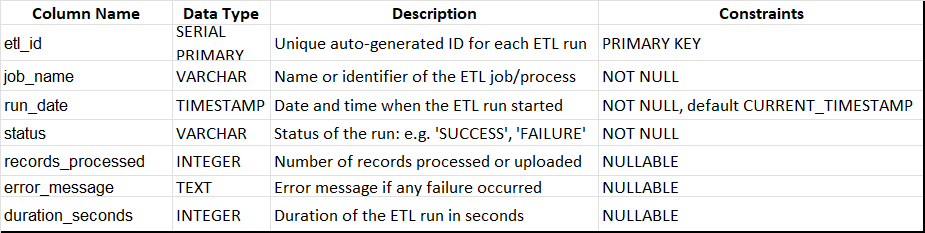

With respect to the above example in Q5, the pipeline details that needs to be logged in can be provided within try and catch block accordingly.


*   job_name (e.g., "Daily Admissions and Imaging ETL")
*   status ("SUCCESS" or "FAILURE")
*   records_processed (you can pass counts from your Python script or get it from logs)
*   error_message (if any error caught in the pipeline)

*   duration_seconds (time taken, can be computed in bash or Python)

In [ ]:
import time

start_time = time.time()

try:
    # ETL processing code here (Q1-Q4 steps) to get the los and q4_df
    # Write to the Postgres db post connection
    # los.write.jdbc(...)
    # q4_df.write.jdbc(...)
    records_processed = los.count() + q4_df.count()  # or any logic to count records processed
    status = "SUCCESS"
    error_message = None

except Exception as e:
    status = "FAILURE"
    error_message = str(e) + "\n" + traceback.format_exc()
    records_processed = None

finally:
    duration = int(time.time() - start_time)
    log_etl_run_to_postgres(
        job_name="Daily Admissions and Imaging ETL",
        status=status,
        records_processed=records_processed,
        error_message=error_message,
        duration_seconds=duration
    )


In [ ]:
#log_etl_run_to_postgres function which can be reused across to write logs into the respective ETL Log table.

def log_etl_run_to_postgres(job_name, status, records_processed=None, error_message=None, duration_seconds=None):
    # Create SparkSession (in Databricks it usually exists as 'spark')
    spark = SparkSession.builder.getOrCreate()

    # Prepare the data as a list of tuples
    log_data = [(job_name, datetime.now(), status, records_processed, error_message, duration_seconds)]

    # Create a DataFrame for the log entry
    log_df = spark.createDataFrame(log_data, schema="""
        job_name STRING,
        run_date TIMESTAMP,
        status STRING,
        records_processed INT,
        error_message STRING,
        duration_seconds INT
    """)

    # Postgres JDBC connection details
    jdbc_url = "jdbc:postgresql://<host>:<port>/<database>"
    connection_properties = {
        "user": "<username>",
        "password": "<password>",
        "driver": "org.postgresql.Driver"
    }

    # Append the log entry to etl_log table
    log_df.write.jdbc(url=jdbc_url, table="etl_log", mode="append", properties=connection_properties)

# finally the Log entry is made into the etl_log table.

# Q7. Consider a table “lab” which stores laboratory results that contains over 500,000,000 rows. Using the following details about the lab table and its relevant columns, how would you optimize query speed on lab? Please explain your answer.



1.   Split the data by hospital (hospital_id)
When saving the table, divide it into parts based on hospital. So, when you ask for data from one hospital, Databricks only looks at that part, not the whole table.
2.   Sort data smartly by patient ID (genc_id) and test name (lab_test_name)
Use something called Z-Ordering. It organizes the data so when you filter by patient or test name, it finds the data faster.
3.   Keep the table tidy and optimized
Run commands regularly that clean up old files and organize the data. This helps Databricks know where to find the data quickly.
4.   Cache data you use a lot
If you often look at data from some hospitals, you can keep that data in memory for quick access.
5.   Only ask for columns you really need
Don’t select every column if you don’t need it. This reduces the amount of data Databricks has to read and speeds up queries.

# Q8. Using the entity relationship diagram (.png file provided in test folder), how would you calculate the missing rate of lab_test_name_mapped_omop of the lab table for patients discharged after 2021-04-01 grouping by hospital_id in SQL.

Steps for SQL Query
*   Join lab and ip_administrative on genc_id.
*   Filter ip_administrative on patients discharged after 2021-04-01.
*   Count total lab records per hospital.
*   Count records where lab_test_name_mapped_omop is NULL or empty (missing).
*   Calculate missing rate = missing count / total count.
*   Group by hospital_id.



```
SELECT
    ip.hospital_id,
    COUNT(*) AS total_lab_records,
    SUM(CASE WHEN lab.lab_test_name_mapped_omop IS NULL OR lab.lab_test_name_mapped_omop = '' THEN 1 ELSE 0 END) AS missing_lab_test_name_mapped_omop,
    ROUND(
        SUM(CASE WHEN lab.lab_test_name_mapped_omop IS NULL OR lab.lab_test_name_mapped_omop = '' THEN 1 ELSE 0 END) * 1.0 / COUNT(*),
        4
    ) AS missing_rate
FROM lab
JOIN ip_administrative ip ON lab.genc_id = ip.genc_id
WHERE ip.discharge_date_time > '2021-04-01'
GROUP BY ip.hospital_id
ORDER BY ip.hospital_id;

```



# Use of AI Assistance

I used ChatGPT to assist with coding snippets, syntax clarifications, and optimization suggestions in some parts of this assessment.
All solutions and explanations were reviewed, adapted, and validated by me to ensure correctness and relevance to the problem statements.